In [1]:
import torch
import odl
import numpy as np
from odl.contrib import torch as odl_torch
from LPD import LPD
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.autograd import Variable
import skimage
import scipy

In [2]:
reco_space = odl.uniform_discr(
    min_pt=[-10, -10], max_pt=[10, 10], shape=[256, 256],
    dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, 256)
detector_partition = odl.uniform_partition(-21, 21, 256)
geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=40, det_radius=40)
forward_proj = odl.tomo.RayTransform(reco_space, geometry)
back_proj = forward_proj.adjoint
forward_proj_layer = odl_torch.OperatorModule(forward_proj)
back_proj_layer = odl_torch.OperatorModule(back_proj)
fbp = odl.tomo.fbp_op(forward_proj, filter_type='Hann')

In [3]:
mat328 = scipy.io.loadmat('Data328.mat')
data328 = mat328['m']
data = scipy.ndimage.zoom(data328, [256/328, 256/120], order=1)
sinogram = forward_proj.range.element(data.T)

In [4]:
true = scipy.io.loadmat('GroundTruthReconstruction.mat')
true = true['FBP1200']
true = scipy.ndimage.zoom(true, [256/2296, 256/2296], order=1)
phantom = true.T
phantom = phantom - np.min(phantom)
phantom = phantom / np.max(phantom)
phantom = reco_space.element(np.squeeze(phantom))

In [5]:
LPD3_UNet3_3 = LPD(3, 3, forward_proj,back_proj)
LPD3_UNet3_3.load_state_dict(torch.load('LPD_3_UNet_3_256_256_10000_3epoch.pth'))

LPD3_UNet4_3 = LPD(3, 4, forward_proj,back_proj)
LPD3_UNet4_3.load_state_dict(torch.load('LPD_3_UNet_4_256_256_10000_3epoch.pth'))

LPD3_UNet5_3 = LPD(3, 5, forward_proj,back_proj)
LPD3_UNet5_3.load_state_dict(torch.load('LPD_3_UNet_5_256_256_10000_3epoch.pth'))

LPD4_UNet3_3 = LPD(4, 3, forward_proj,back_proj)
LPD4_UNet3_3.load_state_dict(torch.load('LPD_4_UNet_3_256_256_10000_3epoch.pth'))

LPD5_UNet3_3 = LPD(5, 3, forward_proj,back_proj)
LPD5_UNet3_3.load_state_dict(torch.load('LPD_5_UNet_3_256_256_10000_3epoch.pth'))

LPD_best = LPD(5, 3, forward_proj,back_proj)
LPD_best.load_state_dict(torch.load('LPD_5_noised_10000_1epoch_2.pth'))

<All keys matched successfully>

In [6]:
g = torch.tensor(np.asarray(sinogram))
g = g[None,None,...]

In [7]:
result_3_3_3 = LPD3_UNet3_3(g).detach().numpy()
result_3_3_3 = result_3_3_3 - np.min(result_3_3_3)
result_3_3_3 = result_3_3_3 / np.max(result_3_3_3)
result_3_3_3 = reco_space.element(np.squeeze(result_3_3_3))

result_3_4_3 = LPD3_UNet4_3(g).detach().numpy()
result_3_4_3 = result_3_4_3 - np.min(result_3_4_3)
result_3_4_3 = result_3_4_3 / np.max(result_3_4_3)
result_3_4_3 = reco_space.element(np.squeeze(result_3_4_3))

result_3_5_3 = LPD3_UNet5_3(g).detach().numpy()
result_3_5_3 = result_3_5_3 - np.min(result_3_5_3)
result_3_5_3 = result_3_5_3 / np.max(result_3_5_3)
result_3_5_3 = reco_space.element(np.squeeze(result_3_5_3))

result_4_3_3 = LPD4_UNet3_3(g).detach().numpy()
result_4_3_3 = result_4_3_3 - np.min(result_4_3_3)
result_4_3_3 = result_4_3_3 / np.max(result_4_3_3)
result_4_3_3 = reco_space.element(np.squeeze(result_4_3_3))

result_5_3_3 = LPD5_UNet3_3(g).detach().numpy()
result_5_3_3 = result_5_3_3 - np.min(result_5_3_3)
result_5_3_3 = result_5_3_3 / np.max(result_5_3_3)
result_5_3_3 = reco_space.element(np.squeeze(result_5_3_3))

result_best = LPD_best(g).detach().numpy()
result_best = result_best - np.min(result_best)
result_best = result_best / np.max(result_best)
result_best = reco_space.element(np.squeeze(result_best))

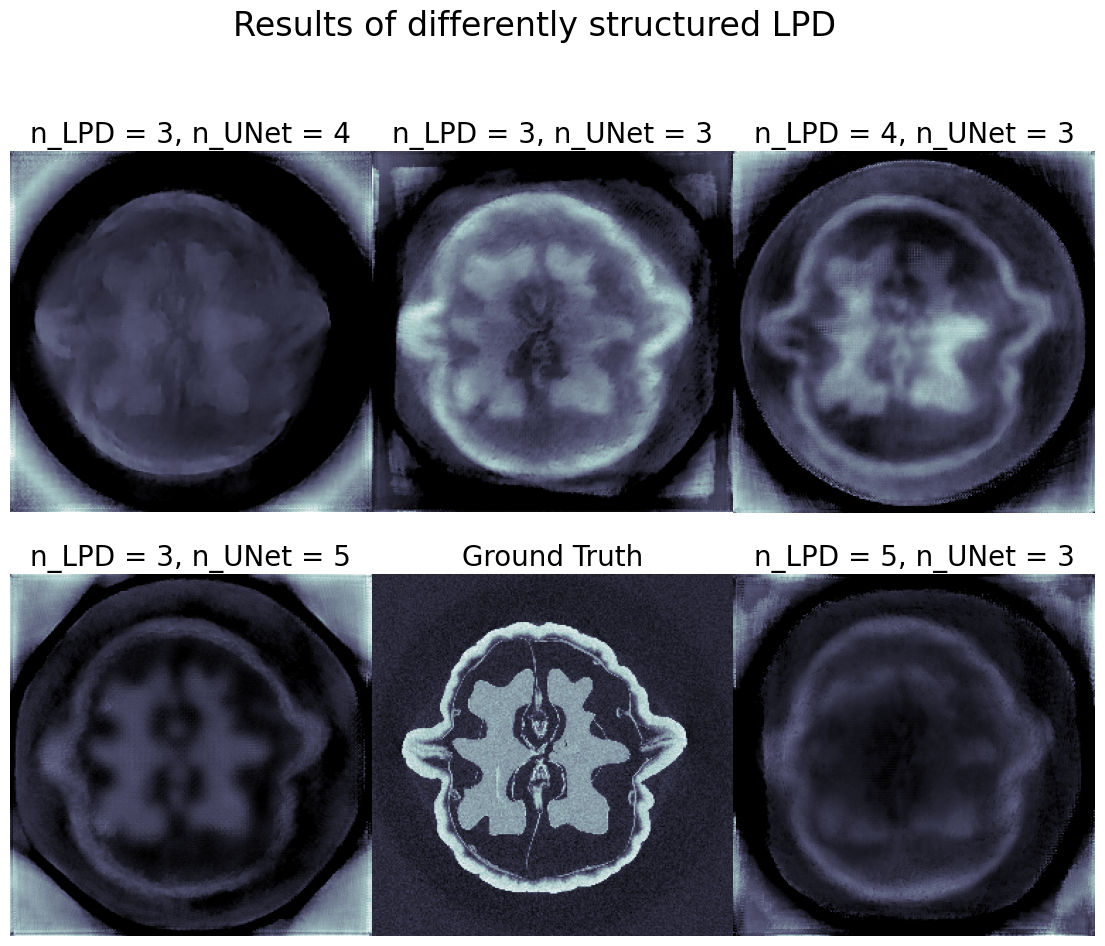

In [8]:
fig, ax = plt.subplots(2,3, figsize = (14,11))

fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Results of differently structured LPD", fontsize = 24)

ax[0,0].imshow(np.transpose(result_3_4_3.data), cmap='bone', origin='lower')
ax[0,0].set_title("n_LPD = 3, n_UNet = 4", fontsize = 20)
ax[0,0].set_axis_off()

ax[1,0].imshow(np.transpose(result_3_5_3.data), cmap='bone', origin='lower')
ax[1,0].set_title("n_LPD = 3, n_UNet = 5", fontsize = 20)
ax[1,0].set_axis_off()

ax[0,1].imshow(np.transpose(result_3_3_3.data), cmap='bone', origin='lower')
ax[0,1].set_title("n_LPD = 3, n_UNet = 3", fontsize = 20)
ax[0,1].set_axis_off()

ax[1,1].imshow(np.transpose(phantom), cmap='bone', origin='lower')
ax[1,1].set_title("Ground Truth", fontsize = 20)
ax[1,1].set_axis_off()

ax[0,2].imshow(np.transpose(result_4_3_3.data), cmap='bone', origin='lower')
ax[0,2].set_title("n_LPD = 4, n_UNet = 3", fontsize = 20)
ax[0,2].set_axis_off()

ax[1,2].imshow(np.transpose(result_5_3_3.data), cmap='bone', origin='lower')
ax[1,2].set_title("n_LPD = 5, n_UNet = 3", fontsize = 20)
ax[1,2].set_axis_off()

plt.show()

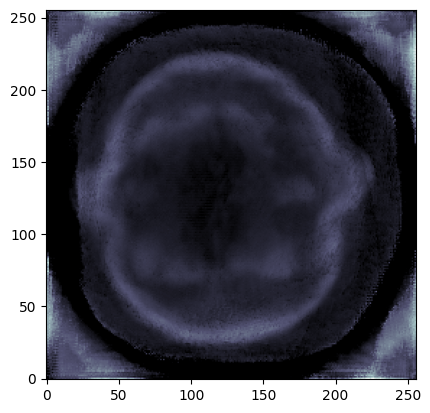

In [9]:
plt.imshow(np.transpose(result_5_3_3.data), cmap='bone', origin='lower')

(-0.5, 255.5, -0.5, 255.5)

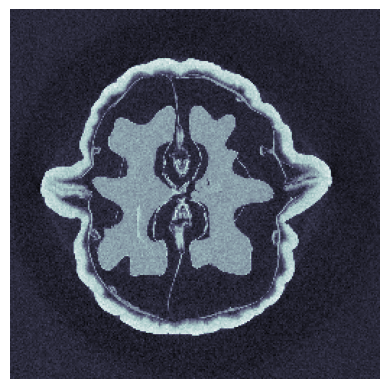

In [30]:
plt.imshow(np.transpose(phantom), cmap='bone', origin='lower')
plt.axis("off")

In [10]:
from math import log10, sqrt 

In [11]:
PSNR = skimage.metrics.peak_signal_noise_ratio
SSIM = skimage.metrics.structural_similarity

In [12]:
psnr333 = PSNR(phantom, result_3_3_3, data_range=1)
psnr343 = PSNR(phantom, result_3_4_3, data_range=1)
psnr353 = PSNR(phantom, result_3_5_3, data_range=1)
psnr433 = PSNR(phantom, result_4_3_3, data_range=1)
psnr533 = PSNR(phantom, result_5_3_3, data_range=1)

In [13]:
ssim333 = SSIM(phantom.data, result_3_3_3.data, data_range=1)
ssim343 = SSIM(phantom.data, result_3_4_3.data, data_range=1)
ssim353 = SSIM(phantom.data, result_3_5_3.data, data_range=1)
ssim433 = SSIM(phantom.data, result_4_3_3.data, data_range=1)
ssim533 = SSIM(phantom.data, result_5_3_3.data, data_range=1)

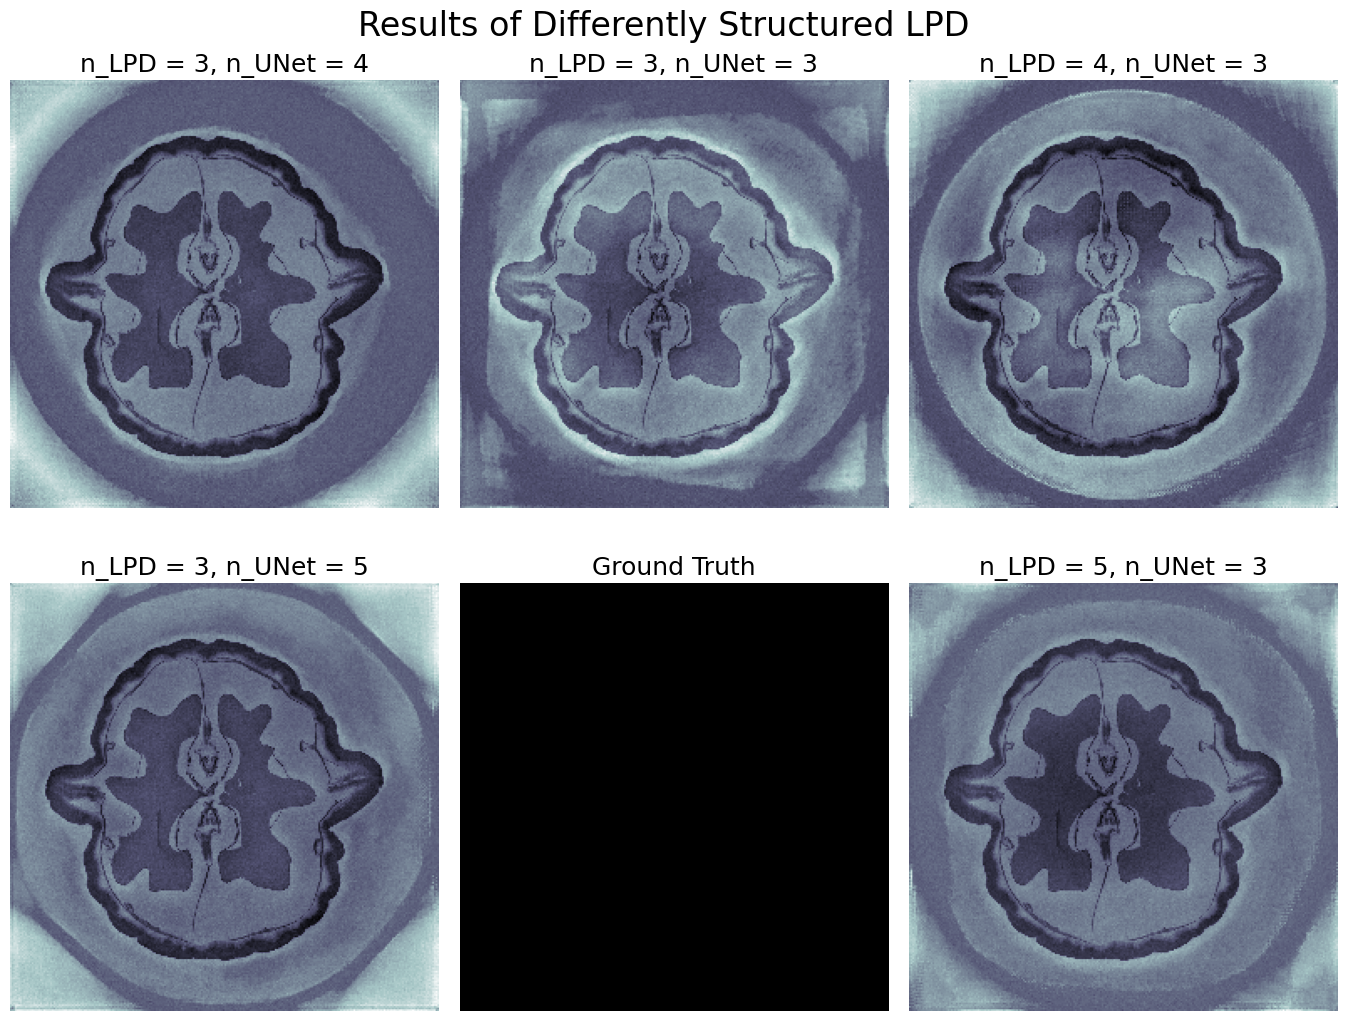

In [14]:
fig, ax = plt.subplots(2,3, figsize = (14,11))

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.suptitle("Results of Differently Structured LPD", fontsize = 24)

ax[0,0].imshow(np.transpose(result_3_4_3.data - phantom), cmap='bone', origin='lower')
ax[0,0].set_title("n_LPD = 3, n_UNet = 4", fontsize = 18)
ax[0,0].set_axis_off()

ax[1,0].imshow(np.transpose(result_3_5_3.data - phantom), cmap='bone', origin='lower')
ax[1,0].set_title("n_LPD = 3, n_UNet = 5", fontsize = 18)
ax[1,0].set_axis_off()

ax[0,1].imshow(np.transpose(result_3_3_3.data - phantom), cmap='bone', origin='lower')
ax[0,1].set_title("n_LPD = 3, n_UNet = 3", fontsize = 18)
ax[0,1].set_axis_off()

ax[1,1].imshow(np.transpose(phantom - phantom), cmap='bone', origin='lower')
ax[1,1].set_title("Ground Truth", fontsize = 18)
ax[1,1].set_axis_off()

ax[0,2].imshow(np.transpose(result_4_3_3.data - phantom), cmap='bone', origin='lower')
ax[0,2].set_title("n_LPD = 4, n_UNet = 3", fontsize = 18)
ax[0,2].set_axis_off()

ax[1,2].imshow(np.transpose(result_5_3_3.data - phantom), cmap='bone', origin='lower')
ax[1,2].set_title("n_LPD = 5, n_UNet = 3", fontsize = 18)
ax[1,2].set_axis_off()

plt.show()

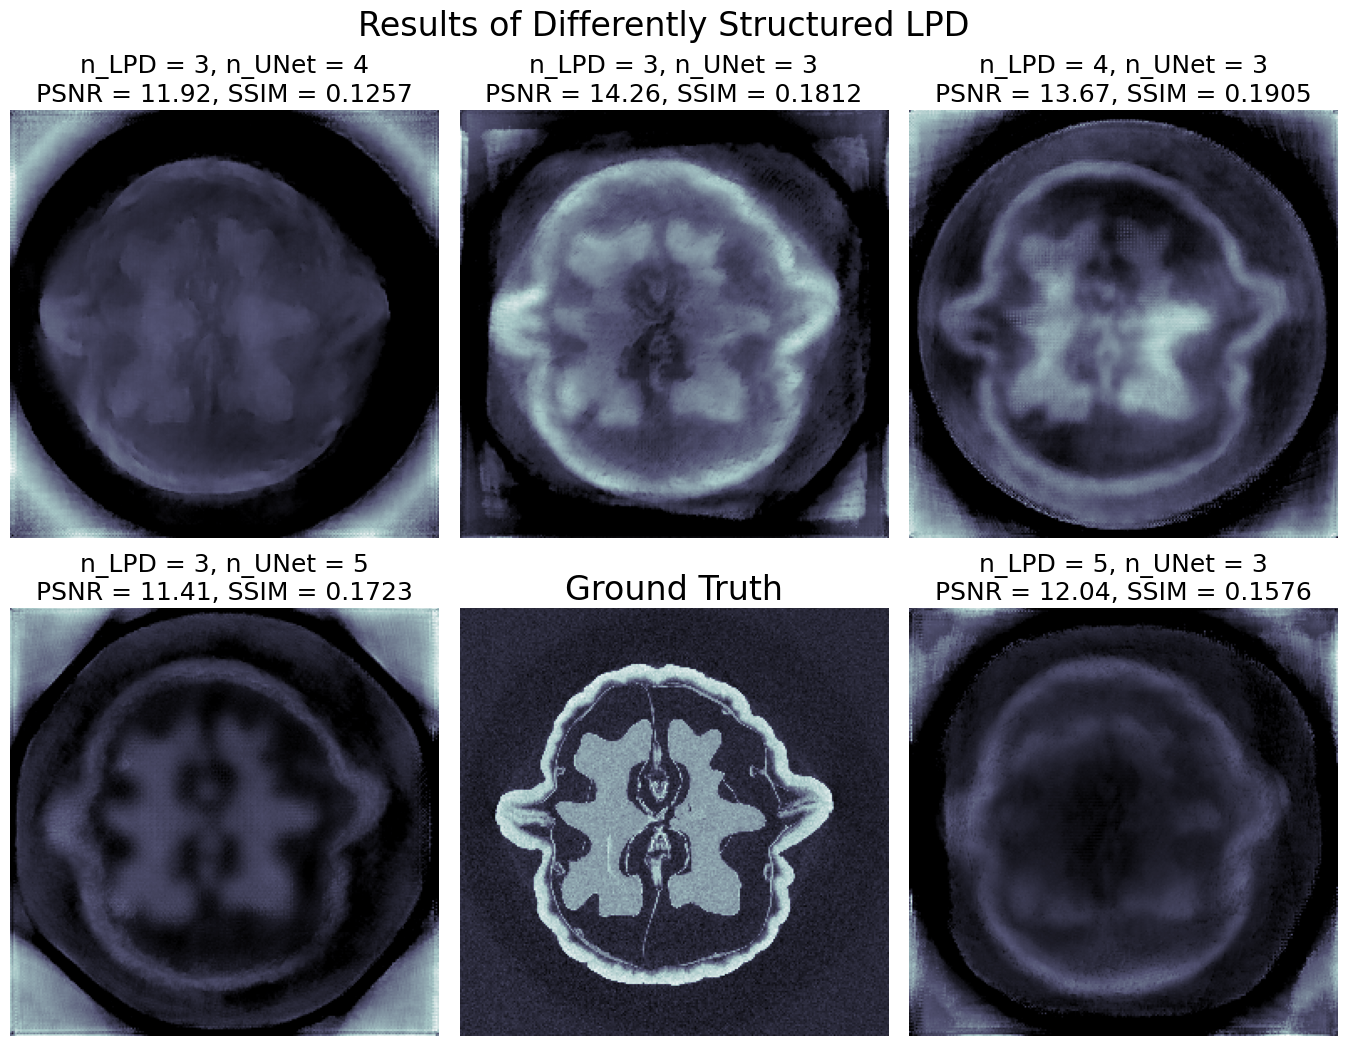

In [15]:
fig, ax = plt.subplots(2,3, figsize = (14,11))

fig.tight_layout()
plt.subplots_adjust(top=0.90)
fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.suptitle("Results of Differently Structured LPD", fontsize = 24)

ax[0,0].imshow(np.transpose(result_3_4_3.data), cmap='bone', origin='lower')
ax[0,0].set_title("n_LPD = 3, n_UNet = 4\nPSNR = " + "{:.2f}".format(psnr343) + ", SSIM = " + "{:.4f}".format(ssim343), fontsize = 18)
ax[0,0].set_axis_off()

ax[1,0].imshow(np.transpose(result_3_5_3.data), cmap='bone', origin='lower')
ax[1,0].set_title("n_LPD = 3, n_UNet = 5\nPSNR = " + "{:.2f}".format(psnr353) + ", SSIM = " + "{:.4f}".format(ssim353), fontsize = 18)
ax[1,0].set_axis_off()

ax[0,1].imshow(np.transpose(result_3_3_3.data), cmap='bone', origin='lower')
ax[0,1].set_title("n_LPD = 3, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnr333) + ", SSIM = " + "{:.4f}".format(ssim333), fontsize = 18)
ax[0,1].set_axis_off()

ax[1,1].imshow(np.transpose(phantom), cmap='bone', origin='lower')
ax[1,1].set_title("Ground Truth", fontsize = 24)
ax[1,1].set_axis_off()

ax[0,2].imshow(np.transpose(result_4_3_3.data), cmap='bone', origin='lower')
ax[0,2].set_title("n_LPD = 4, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnr433) + ", SSIM = " + "{:.4f}".format(ssim433), fontsize = 18)
ax[0,2].set_axis_off()

ax[1,2].imshow(np.transpose(result_5_3_3.data), cmap='bone', origin='lower')
ax[1,2].set_title("n_LPD = 5, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnr533) + ", SSIM = " + "{:.4f}".format(ssim533), fontsize = 18)
ax[1,2].set_axis_off()

plt.show()

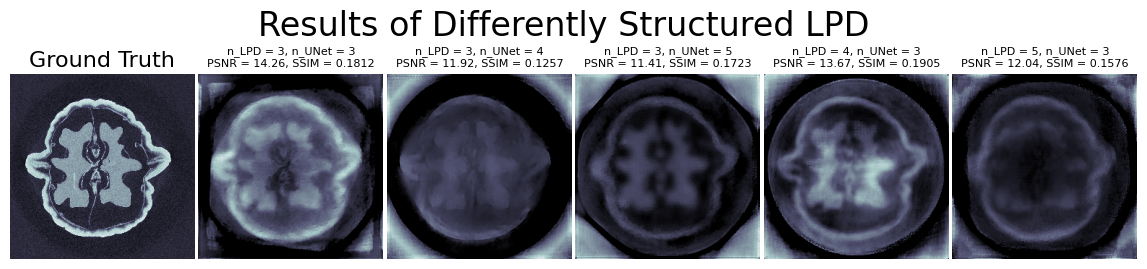

In [16]:
fig, ax = plt.subplots(1,6, figsize = (12,3.5))

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.subplots_adjust(wspace=0.02, hspace=0.01)
fig.suptitle("Results of Differently Structured LPD", fontsize = 24)

ax[2].imshow(np.transpose(result_3_4_3.data), cmap='bone', origin='lower')
ax[2].set_title("n_LPD = 3, n_UNet = 4\nPSNR = " + "{:.2f}".format(psnr343) + ", SSIM = " + "{:.4f}".format(ssim343), fontsize = 8)
ax[2].set_axis_off()

ax[3].imshow(np.transpose(result_3_5_3.data), cmap='bone', origin='lower')
ax[3].set_title("n_LPD = 3, n_UNet = 5\nPSNR = " + "{:.2f}".format(psnr353) + ", SSIM = " + "{:.4f}".format(ssim353), fontsize = 8)
ax[3].set_axis_off()

ax[1].imshow(np.transpose(result_3_3_3.data), cmap='bone', origin='lower')
ax[1].set_title("n_LPD = 3, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnr333) + ", SSIM = " + "{:.4f}".format(ssim333), fontsize = 8)
ax[1].set_axis_off()

ax[0].imshow(np.transpose(phantom), cmap='bone', origin='lower')
ax[0].set_title("Ground Truth", fontsize = 16)
ax[0].set_axis_off()

ax[4].imshow(np.transpose(result_4_3_3.data), cmap='bone', origin='lower')
ax[4].set_title("n_LPD = 4, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnr433) + ", SSIM = " + "{:.4f}".format(ssim433), fontsize = 8)
ax[4].set_axis_off()

ax[5].imshow(np.transpose(result_5_3_3.data), cmap='bone', origin='lower')
ax[5].set_title("n_LPD = 5, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnr533) + ", SSIM = " + "{:.4f}".format(ssim533), fontsize = 8)
ax[5].set_axis_off()

plt.show()

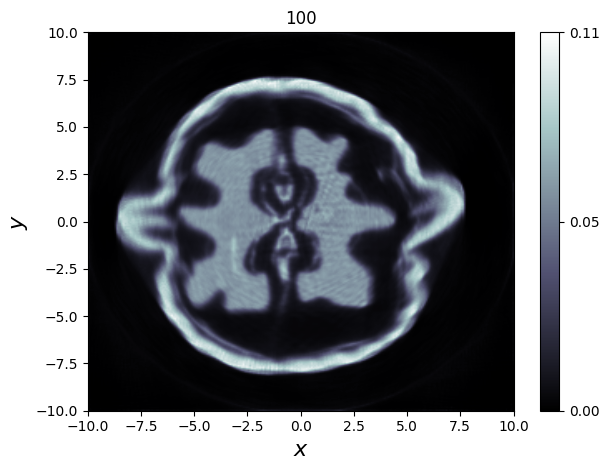

<Figure size 640x480 with 0 Axes>

In [17]:
mlem_rec = back_proj(sinogram)
sino_ones = np.ones(sinogram.shape)
sens_image = back_proj(sino_ones)
p = 0

for i in range(100):
    ratio = sinogram / (forward_proj(mlem_rec)+0.0000000000001)
    correction = back_proj(ratio) / sens_image
    mlem_rec = mlem_rec * correction
    mlem_rec.show(title=str(i+1))
    clear_output(wait=True)
    

mlem_rec = mlem_rec - np.min(mlem_rec)
mlem_rec = mlem_rec / np.max(mlem_rec)

In [18]:
fbp = odl.tomo.fbp_op(forward_proj, filter_type='Hann', frequency_scaling=0.8)

In [19]:
fbp_rec = fbp(sinogram)
fbp_rec = fbp_rec - np.min(fbp_rec)
fbp_rec = fbp_rec / np.max(fbp_rec)

In [20]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, x_reshaped, y_reshaped):
        loss = (torch.sum((ray_transform_layer(x_reshaped) - y_reshaped) ** 2) +
        50 * (torch.sum(torch.abs(grad_layer(x_reshaped)))))
        return loss.mean()

In [21]:
grad = odl.Gradient(reco_space)
ray_transform_layer = odl_torch.OperatorModule(forward_proj)
grad_layer = odl_torch.OperatorModule(grad)
x = Variable(torch.zeros(reco_space.shape), requires_grad=True)
y = torch.tensor(np.asarray(sinogram))

x_reshaped = Variable(torch.tensor(np.zeros(reco_space.shape)[None, None, ...]), requires_grad=True)
y_reshaped = y[None, None, ...]

x_reshaped = Variable(torch.tensor(np.zeros(reco_space.shape)[None, None, ...]), requires_grad=True)
loss_fn = CustomLoss()
optimizer = torch.optim.Adam([x_reshaped], lr=1e-1)
for epoch in range(0,1000):
    # Forward pass
    loss = loss_fn(x_reshaped, y_reshaped)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    grad_rec = reco_space.element(np.squeeze(x_reshaped.detach().numpy()))
    #clear_output(wait=True)
    #reconstructed_image.show(title=('iteration ' + str(epoch)))

grad_rec = grad_rec - np.min(grad_rec)
grad_rec = grad_rec / np.max(grad_rec)

In [22]:
no_rec = back_proj(sinogram)

no_rec = no_rec - np.min(no_rec)
no_rec = no_rec / np.max(no_rec)

In [23]:
lpd_rec = result_5_3_3

In [24]:
psnrno = PSNR(phantom, no_rec, data_range=1)
psnrfbp = PSNR(phantom, fbp_rec, data_range=1)
psnrgrad = PSNR(phantom, grad_rec, data_range=1)
psnrmlem = PSNR(phantom, mlem_rec, data_range=1)
psnrlpd = PSNR(phantom, lpd_rec, data_range=1)

In [25]:
ssimno = SSIM(phantom.data, no_rec.data, data_range=1)
ssimfbp = SSIM(phantom.data, fbp_rec.data, data_range=1)
ssimgrad = SSIM(phantom.data, grad_rec.data, data_range=1)
ssimmlem = SSIM(phantom.data, mlem_rec.data, data_range=1)
ssimlpd = SSIM(phantom.data, lpd_rec.data, data_range=1)

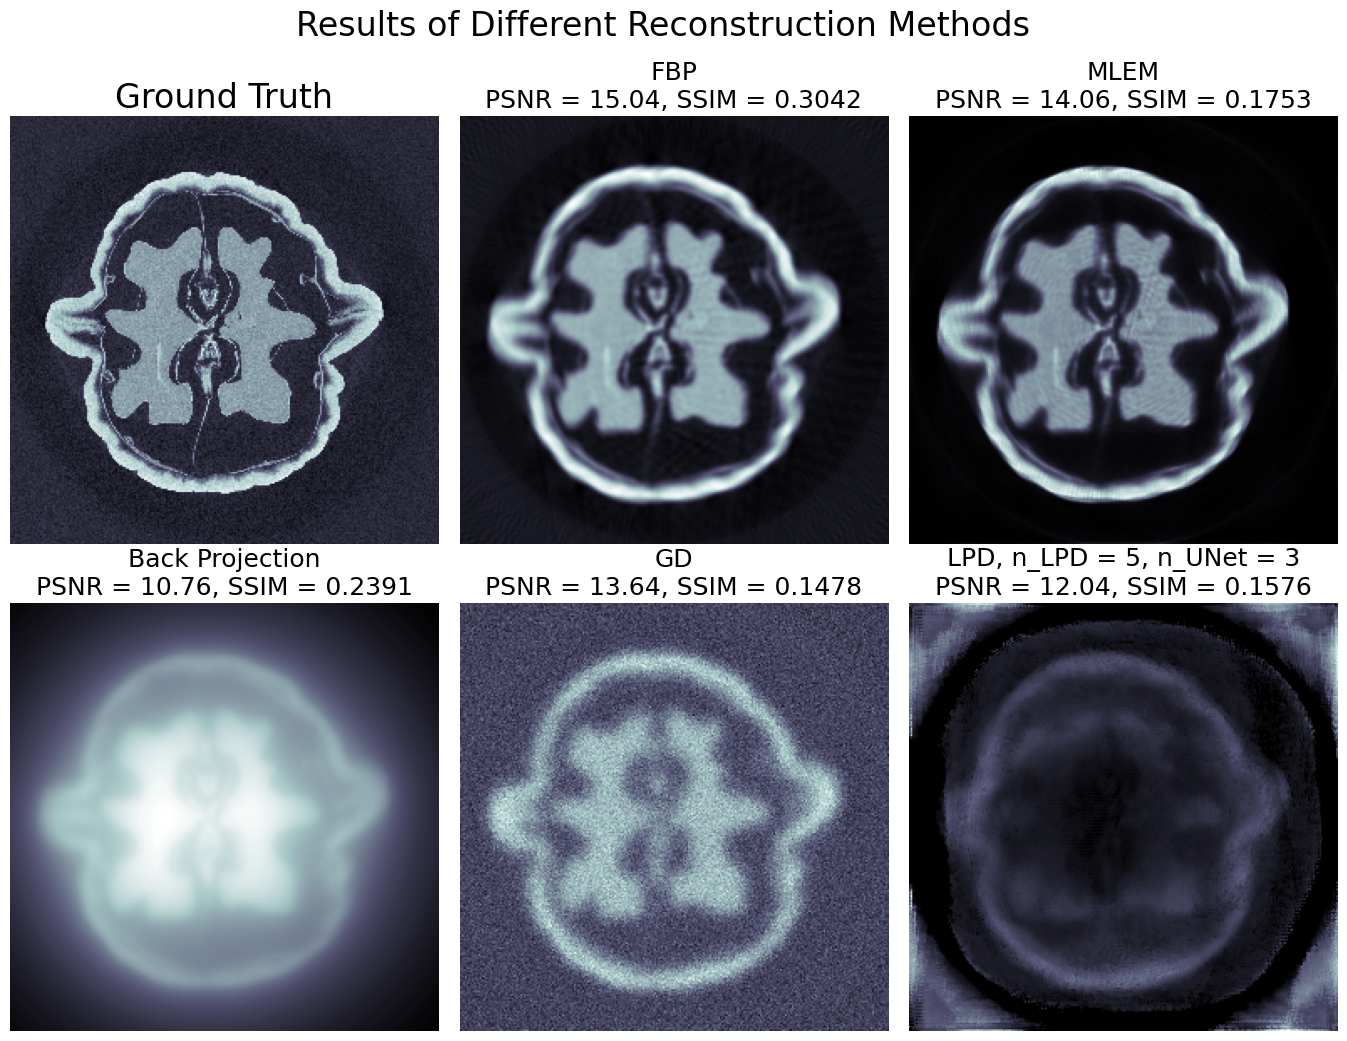

In [26]:
fig, ax = plt.subplots(2,3, figsize = (14,11))

fig.tight_layout()
plt.subplots_adjust(top=0.90)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle("Results of Different Reconstruction Methods", fontsize = 24)

ax[0,0].imshow(np.transpose(phantom).data, cmap='bone', origin='lower')
ax[0,0].set_title("Ground Truth", fontsize = 24)
ax[0,0].set_axis_off()

ax[1,0].imshow(np.transpose(no_rec.data), cmap='bone', origin='lower')
ax[1,0].set_title("Back Projection\nPSNR = " + "{:.2f}".format(psnrno) + ", SSIM = " + "{:.4f}".format(ssimno), fontsize = 18)
ax[1,0].set_axis_off()

ax[0,1].imshow(np.transpose(fbp_rec.data), cmap='bone', origin='lower')
ax[0,1].set_title("FBP\nPSNR = " + "{:.2f}".format(psnrfbp) + ", SSIM = " + "{:.4f}".format(ssimfbp), fontsize = 18)
ax[0,1].set_axis_off()

ax[1,1].imshow(np.transpose(grad_rec.data), cmap='bone', origin='lower')
ax[1,1].set_title("GD\nPSNR = " + "{:.2f}".format(psnrgrad) + ", SSIM = " + "{:.4f}".format(ssimgrad), fontsize = 18)
ax[1,1].set_axis_off()

ax[0,2].imshow(np.transpose(mlem_rec.data), cmap='bone', origin='lower')
ax[0,2].set_title("MLEM\nPSNR = " + "{:.2f}".format(psnrmlem) + ", SSIM = " + "{:.4f}".format(ssimmlem), fontsize = 18)
ax[0,2].set_axis_off()

ax[1,2].imshow(np.transpose(lpd_rec.data), cmap='bone', origin='lower')
ax[1,2].set_title("LPD, n_LPD = 5, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnrlpd) + ", SSIM = " + "{:.4f}".format(ssimlpd), fontsize = 18)
ax[1,2].set_axis_off()

plt.show()

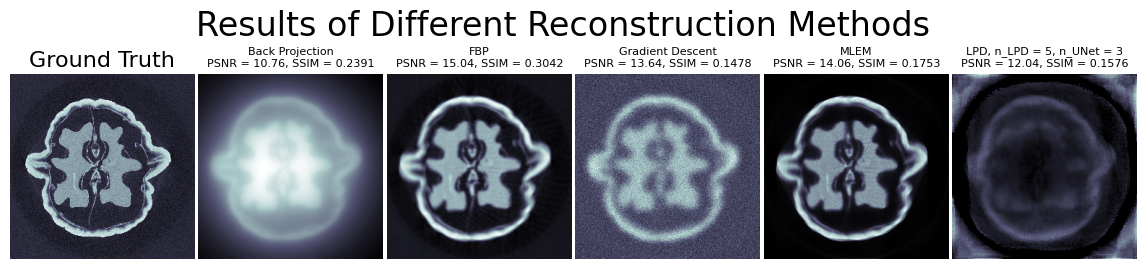

In [27]:
fig, ax = plt.subplots(1,6, figsize = (12,3.5))

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.subplots_adjust(wspace=0.02, hspace=0.01)
fig.suptitle("Results of Different Reconstruction Methods", fontsize = 24)

ax[0].imshow(np.transpose(phantom).data, cmap='bone', origin='lower')
ax[0].set_title("Ground Truth", fontsize = 16)
ax[0].set_axis_off()

ax[1].imshow(np.transpose(no_rec.data), cmap='bone', origin='lower')
ax[1].set_title("Back Projection\nPSNR = " + "{:.2f}".format(psnrno) + ", SSIM = " + "{:.4f}".format(ssimno), fontsize = 8)
ax[1].set_axis_off()

ax[2].imshow(np.transpose(fbp_rec.data), cmap='bone', origin='lower')
ax[2].set_title("FBP\nPSNR = " + "{:.2f}".format(psnrfbp) + ", SSIM = " + "{:.4f}".format(ssimfbp), fontsize = 8)
ax[2].set_axis_off()

ax[3].imshow(np.transpose(grad_rec.data), cmap='bone', origin='lower')
ax[3].set_title("Gradient Descent\nPSNR = " + "{:.2f}".format(psnrgrad) + ", SSIM = " + "{:.4f}".format(ssimgrad), fontsize = 8)
ax[3].set_axis_off()

ax[4].imshow(np.transpose(mlem_rec.data), cmap='bone', origin='lower')
ax[4].set_title("MLEM\nPSNR = " + "{:.2f}".format(psnrmlem) + ", SSIM = " + "{:.4f}".format(ssimmlem), fontsize = 8)
ax[4].set_axis_off()

ax[5].imshow(np.transpose(lpd_rec.data), cmap='bone', origin='lower')
ax[5].set_title("LPD, n_LPD = 5, n_UNet = 3\nPSNR = " + "{:.2f}".format(psnrlpd) + ", SSIM = " + "{:.4f}".format(ssimlpd), fontsize = 8)
ax[5].set_axis_off()

plt.show()

d:\anaconda3\envs\odl-py39-pt\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


inf

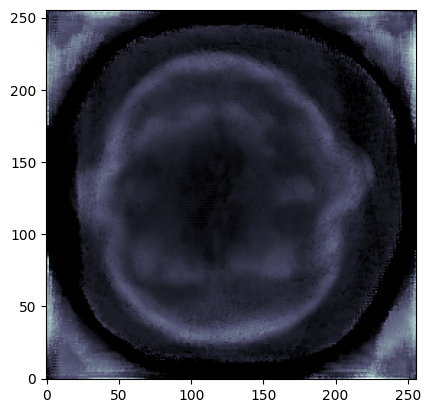

In [28]:
t = np.array(lpd_rec.data)
t[t>0.95]=0.95
plt.imshow(np.transpose(t), cmap='bone', origin='lower')
PSNR(phantom, phantom)